In [2]:
from ml_bay12.GCS import GCSLoader
from ml_bay12 import data_prepare
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
gcs=GCSLoader(project='open-mafia-ml-bay12',path='om-ml-bay12-storage/dataset/ds_mafia')
post_train=gcs.get_post()
role_train=gcs.get_role()
post_test=gcs.get_post(which='test')
role_test=gcs.get_role(which='test')

In [5]:
post_train["text"]=post_train["text"].apply(data_prepare.clean)
post_test["text"]=post_test["text"].apply(data_prepare.clean)

In [6]:
users_df=data_prepare.concat_users_text(post_train)
users_test_df=data_prepare.concat_users_text(post_test)


In [7]:
main_df = data_prepare.get_users_in_game(role_train, users_df)
main_test_df = data_prepare.get_users_in_game(role_test, users_test_df)

In [8]:
train_data=main_df["text"]
y=main_df["role_id"]
y_test=gcs.get_role_answers()["role_id"]
test_data=main_test_df["text"]


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
vectorizer = TfidfVectorizer()
X_vect_train =vectorizer.fit_transform(train_data)
X_vect_test =vectorizer.transform(test_data)
X_vect_train

<478x28543 sparse matrix of type '<class 'numpy.float64'>'
	with 288883 stored elements in Compressed Sparse Row format>

In [11]:
from sklearn.decomposition import TruncatedSVD

In [12]:
lsa = TruncatedSVD(n_components=100, random_state=0)
X_train = lsa.fit_transform(X_vect_train)
X_test = lsa.transform(X_vect_test)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [14]:
params = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver':['newton-cg', 'lbfgs','sag']}

clf = GridSearchCV(LogisticRegression(random_state=0, class_weight='balanced'), params,cv=None)

In [15]:
clf.fit(X_train,y)
clf.best_params_

C:\Software\Anaconda3\envs\ml-bay12\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 100, 'solver': 'sag'}

In [16]:
pred_y = clf.predict(X_test)
probs_y = clf.predict_proba(X_test)
X_test.shape

(335, 100)

In [17]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc

In [18]:
roc_auc_score(y_test, probs_y[:,1])

0.5510825102264791

(0, 1)

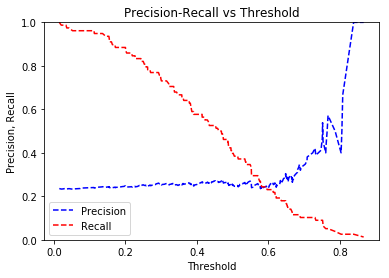

In [19]:
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:,1]) 

pr_auc = auc(recall, precision)

plt.title("Precision-Recall vs Threshold")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])